# Group 7 --- Baseline Model

## Data Preparation

### Import Feature Matrix

As prepared in the previous assignment (Data Treatment), the feature matrix is stored in a .csv file, which contains features extracted from raw data based on physical meanings, as well as the labels indicating whether the material passes FR tests or not. A total of 41 observations and 5 features were included. Specifically, the output consists of 3 labels, where 0=fail, 1=pass, 2=hard to determine.

We start by importing the .csv file. Appropriate libraries are imported.

In [1]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
data = pd.read_csv("./data/feature_matrix.csv")
data.head(5)

Total Heat Release  Burning Temperature  Ignition Temperature  \
0        70804.665602              754.030               350.805   
1        63476.868319              753.809               437.651   
2        34511.238068              568.956               366.975   
3        85034.811235              754.036               397.540   
4       138659.625788              753.505               388.929   

   Heat Release Capacity  Fire Growth Capacity  FR_labels  
0           74333.858118             78.474177          2  
1           66516.283868            113.679065          2  
2           36145.327129            107.418877          1  
3           89645.547156            121.889424          0  
4          146027.526921            189.996708          0

### Scale Data

Based on simple observation on the raw features, it is not suprised to see there are magnitude difference among all features. To eliminate the weight bias caused by descrepancy with units, standard scaling is applied and all analysis will be performed on top of the scaled dataset.

In [2]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# scale the data (excluding labels)
scaler = StandardScaler()
scaled = scaler.fit_transform(data.drop(columns='FR_labels'))
scaled = pd.DataFrame(scaled)
scaled['FR_labels'] = data.loc[:,'FR_labels']    # add FR_labels to new dataframe
scaled.columns = data.columns    # add column headers back to new dataframe
scaled.head()

Total Heat Release  Burning Temperature  Ignition Temperature  \
0           -0.408224             0.166802             -0.989892   
1           -0.568765             0.159051              0.726639   
2           -1.203354            -6.324448             -0.670288   
3           -0.096465             0.167013             -0.066164   
4            1.078367             0.148389             -0.236362   

   Heat Release Capacity  Fire Growth Capacity  FR_labels  
0              -0.420134             -0.524170          2  
1              -0.582476             -0.272429          2  
2              -1.213169             -0.317194          1  
3              -0.102167             -0.213719          0  
4               1.068679              0.273298          0

A histogram for each feature and output has been printed to check the distribution. Each histogram of the features shows ~1-2 outliers that may affect the model performance. Noticably, Burning temperature's histogram distribution is significantly skewed by a single outlier with $T_b=-6.32$. This causes the range of values ~0.14-0.17 to only show up in a single column rather than a distribution.

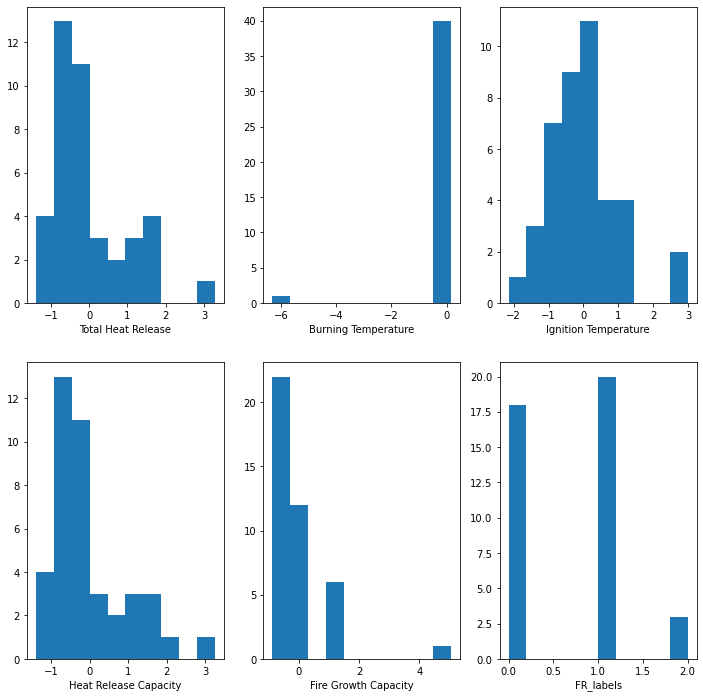

In [3]:
# Plot a histogram for each feature and output to check the distribution of scaled data
X = scaled.values
x_names = [str(x) for x in data.columns[0:6]]
N = X.shape[-1]
n = int(np.sqrt(N))
fig, axes = plt.subplots(n, n+1, figsize = (6*n, 6*n))
ax_list = axes.ravel()
for i in range(N):
  ax_list[i].hist(X[:,i])
  ax_list[i].set_xlabel(x_names[i])

### Drop outliers and analysis of correlation matrix

A plot for each pair of features was generated with a kernel density estimatation (kde) created on the diagonal. An interesting thing to note is that the probability density function for flame retardant test pass/fails is 'almost' separable, meaning it might be possible to generate a new feature that allows for effective classification. Additionally, due to the relatively normal distribution of features, it might be possible to use a Gaussian Naive Bayes model to generate new data points, which would be extremely beneficial for our small dataset.

The kde plot for burning temperature further illustrates the affect of the outlier on the data. We will keep everything as is for the purpose of a baseline model but definitely need to factor this in to our assessment of the model performance.

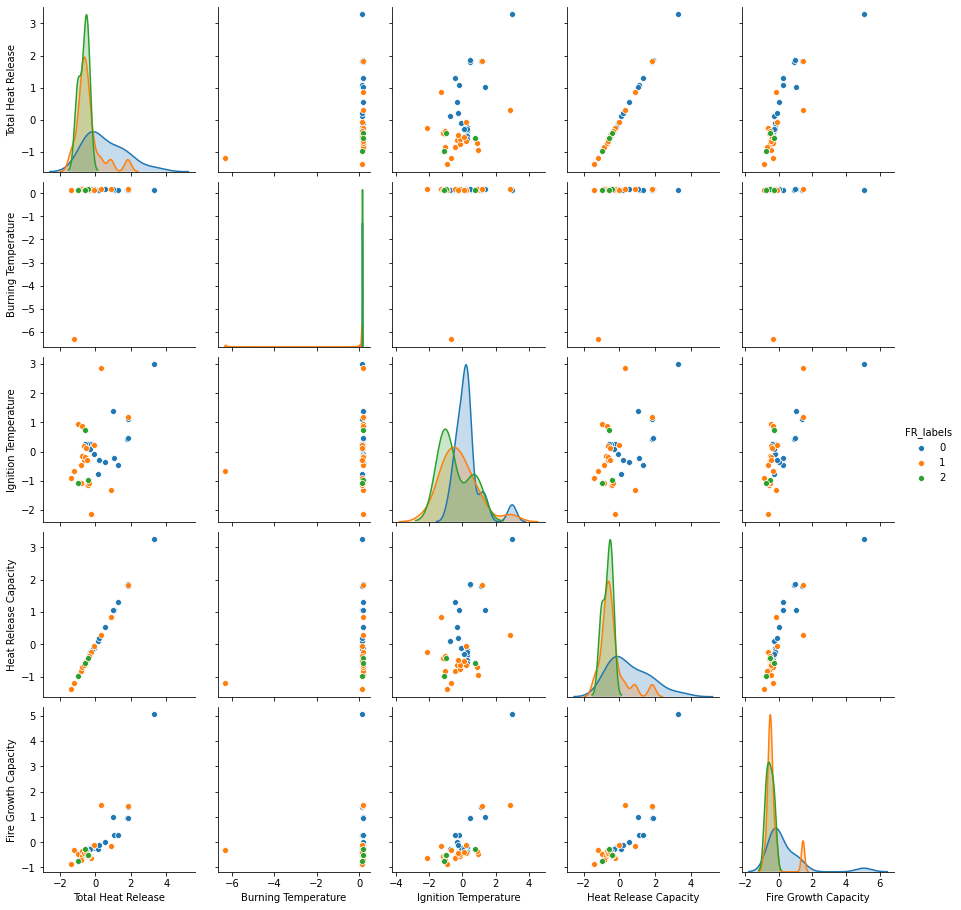

In [4]:
# Seaborn's kernel density estimation (diagonal) shows the effect of the outlier -6 value on the probability distribution.
# We will have to investigate the cause for this one outlier but will drop it for now.
import seaborn as sns
sns.pairplot(scaled,hue='FR_labels')

Dropping the outlier leads to much more visibility within the plots and shows that the previous features paired with burning temperature are not as separable in 2D as we hoped.

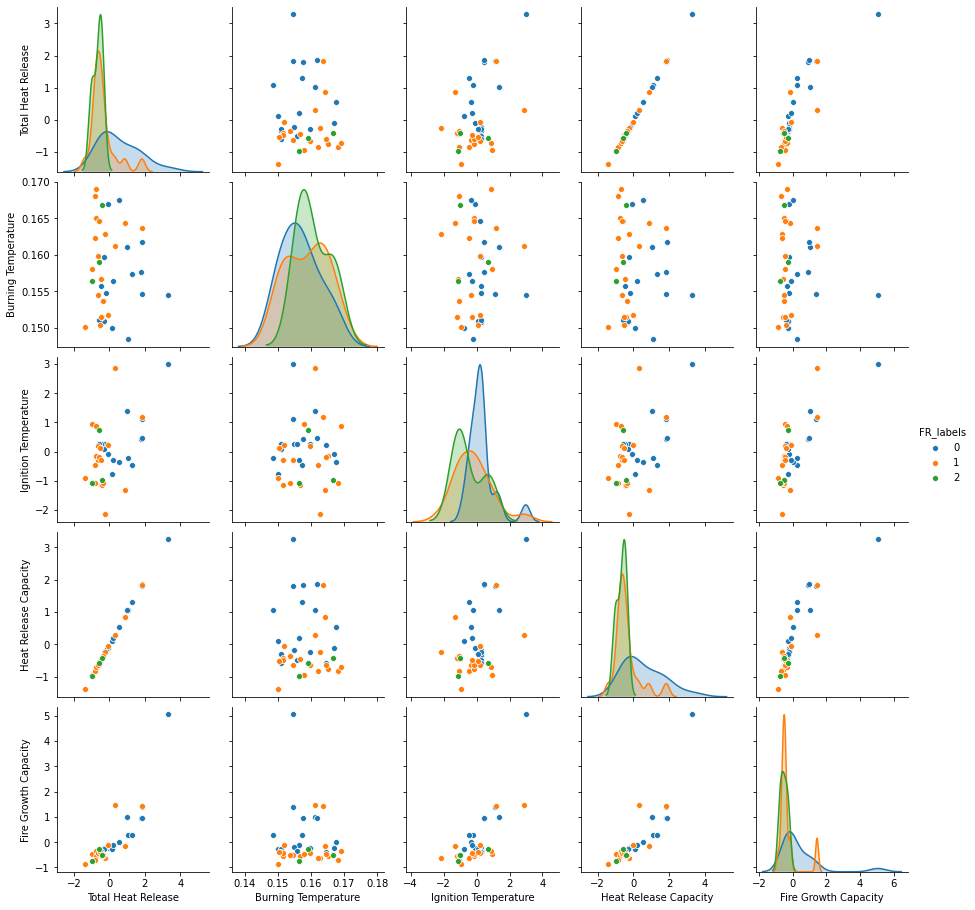

In [5]:
# dropped outlier
dropped = scaled.drop(index=2)
sns.pairplot(dropped,hue='FR_labels')

Finally a correlation matrix shows that the 'Total Heat Release' and the 'Heat Release Capacity' features are highly correlated. We will consider the redundancy in future models. Interestingly, burnint temperature has no correlation with any other feature.

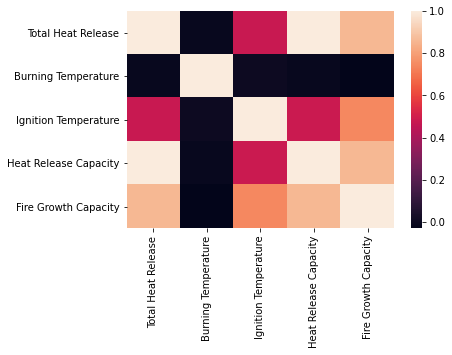

In [6]:
# plot correlation matrix
sns.heatmap(dropped.drop(columns='FR_labels').corr())

## Baseline Model

### Build baseline model and fit the scaled features

According to the pipeline diagram in our description file, a 90% train-test split will be performed to the scaled dataset. Support Vector Classifier (SVC) is selected as our baseline model. GridSearchCV is used for determining the optimal hyperparameters ($C$ and $\gamma$) with a 3-fold cross-validation. At the end, the accuracy, precision and recall scores are printed as benchmark metrics with other potential models.

Our SVC baseline model will not consider previously discussed issues of multicollinearity and outliers with the data but will establish the baseline performance for a classification model. Because dropping the outlier at index=2 made a significant difference, we will be dropping that data point for the baseline but further exploring its significance in the future.

In [7]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# perform a train-test split. 90% of original data will be used for training
X = dropped.drop(columns='FR_labels').values
y = dropped['FR_labels'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

# define support vector model with rbf kernel
svc = SVC(kernel = 'rbf')

# build up parameter grid and perform GridSearchCV to find the best estimator
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas
sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

param_grid = {'C': Cs,'gamma': gammas}

svc_search = GridSearchCV(svc, param_grid, cv = 3)
svc_search.fit(X_train,y_train)

# resulting predictions
predict_svc = svc_search.best_estimator_.predict(X_test)
full_predict_svc = svc_search.best_estimator_.predict(X)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test, predict_svc)))
print('Precision for validation set: {}'.format(precision_score(y_test, predict_svc, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test, predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y, full_predict_svc)))
print('Precision for full dataset: {}'.format(precision_score(y, full_predict_svc, average='macro')))
print('Recall for full dataset: {}'.format(recall_score(y, full_predict_svc, average='macro')))


Accuracy for validation set: 0.75
Precision for validation set: 0.75
Recall for validation set: 0.8333333333333333

Accuracy for full dataset: 0.8
Precision for full dataset: 0.5353535353535354
Recall for full dataset: 0.5760233918128655


C:\Users\oscsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After running the above cell a few times, we notice that the score changes drastically based on the random set of X_train, y_train chosen. This is caused by our small data set and should be addressed in future models by generating or obtaining additional data. Additionally, due to the same problem, sometimes the model is unable to predict the borderline class (label 2) shown in the warning above, which is composed of materials that do not have a fixed flame retardant test result (sometimes pass and sometimes fail).

With regards to scores of the validation set and the full dataset, it seems that the data is not overfitting much and seems to generalize well when applied to the larger data set.

### Output analysis and paths forward

Thus far, a complete pipeline connecting feature matrix to results has been built up. The SVC baseline model, itself, provides a decent but not perfect performance on the validation set. It's still worth trying to improve the based model and do futher analysis in the future. The possible paths will include but not limited to:

(1) Try other classification models such as random forest, neural network, etc. Compare the performance of each model.

(2) Extract more features from raw data using principle component analysis (PCA). Compare the performance among different feature combinations. For example, calculate and compare the metrics of models using (a)features with physical meaning alone, (b) features extracted by PCA alone, and (c) combination of both.

(3) There are three classes for the output. Only two materials fall in the category of class 2 (hard to determine), whereas the other two classes (class 0 & 1) distribute almost evenly. Resampling method and generative methods such as Gaussian Naive Bayes method can be applied to fix the problem.

(4) Due to the small size of our dataset, the fitting scores will largely depend on the train-test split. It might be improved by generating or obtaining new data.